<a href="https://colab.research.google.com/github/habhishek/nlp_samples/blob/main/nlp_poetry.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from __future__ import print_function, division
from builtins import range, input

In [2]:
import os
import sys
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.models import Model
from keras.layers import Dense, Embedding, Input, LSTM
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.optimizers import Adam, SGD

In [3]:
try:
  import keras.backend as K
  if len(K.tensorflow_backend.__get_available_gpus()) > 0:
    from keras.layers import CuDNNLSTM as LSTM
    from keras.layers import CuDNNGRU as GRU
except:
  pass

### Some Initialisations

In [4]:
MAX_SEQUENCE_LENGTH = 100
MAX_VOCAB_SIZE = 3000
EMBEDDING_DIM = 50
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 120
EPOCHS = 2000
LATENT_DIM = 25

### Loading the Data

Read in the text file and strip each line and make in an input sample. Since we are generating poetry or creating a language model that predicts the next word, the labels or targets will be the same line. If first word is "sos", the target label should be the first word on the input sequence on so on. For the targets, an extra token - the "eos" is added to mark the end of sentence

In [5]:
# load in the data
input_texts = []
target_texts = []
for line in open('RobertFrost.txt'):
  line = line.rstrip()
  if not line:
    continue
  
  input_line = '<sos> ' + line
  target_line = line + ' <eos>'

  input_texts.append(input_line)
  target_texts.append(target_line)

all_lines = input_texts + target_texts


### Tokenize

Maps the input words of the sequnces to integers. The idea is to create a vocabulary of all the words in the corpus of training data. Then, represent each word by its index in the vocabulary.
Now its also important to save the index mapping in a dictionary to later on refer to the original word.

In [6]:
# Convert the sentences in integers
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, filters='')
tokenizer.fit_on_texts(all_lines)
input_sequences = tokenizer.texts_to_sequences(input_texts)
target_sequences = tokenizer.texts_to_sequences(target_texts)

# find max seq length
max_sequence_length_from_data = max(len(s) for s in input_sequences)
print('Max Sequence Length:', max_sequence_length_from_data)

# get word -> interger mapping
word2idx = tokenizer.word_index
print('Found {0} unique tokens.'.format(len(word2idx)))
assert('<sos>' in word2idx)
assert('<eos>' in word2idx)

Max Sequence Length: 12
Found 3056 unique tokens.


### Now pad the input sequences

In [7]:
# pad the sequences so that we get standard NxT matrix
max_sequence_length = min(max_sequence_length_from_data, MAX_SEQUENCE_LENGTH)
input_sequences = pad_sequences(input_sequences, max_sequence_length, padding='post')
target_sequences = pad_sequences(target_sequences, max_sequence_length, padding='post')

### Prepare the Embedding Matrix using the Pre-Trained GloVe Word Vectors

#### Download the GloVe pre-trained vector files



In [8]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

--2021-07-20 18:07:05--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2021-07-20 18:07:05--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-07-20 18:07:05--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

#### Prepare the word2vec dictionary with word vector mappings

In [9]:
print('Loading word vectors...')

word2vec = {}
with open('glove.6B.{0}d.txt'.format(EMBEDDING_DIM)) as f:
  for line in f:
    values = line.split()
    word = values[0]
    vec = np.asarray(values[1:], dtype='float32')
    word2vec[word] = vec

print('Found %s word vectors.' % len(word2vec))


Loading word vectors...
Found 400000 word vectors.


#### Now create the embedding matrix

Now, let's prepare a corresponding embedding matrix that we can use in a Keras Embedding layer. It's a simple NumPy matrix where entry at index i is the pre-trained vector for the word of index i in our vectorizer's vocabulary

In [10]:
num_words = min(MAX_VOCAB_SIZE, len(word2idx)+1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
hits = 0
misses = 0
for word, i in word2idx.items():
  if i < MAX_VOCAB_SIZE:
    embedding_vector = word2vec.get(word)
    if embedding_vector is not None:
      embedding_matrix[i] = embedding_vector
      hits += 1
    else:
      misses += 1

print('Converted {0} words ({1} missses)'.format(hits, misses))
    

Converted 1642 words (1357 missses)


Convert the targets into one-hot vectors

In [11]:
one_hot_targets = np.zeros((len(input_sequences), max_sequence_length, num_words))
for i, target_sequence in enumerate(target_sequences):
  for t, word in enumerate(target_sequence):
    if word > 0:
      one_hot_targets[i, t, word] = 1

In [12]:
one_hot_targets[0,0]

array([0., 0., 0., ..., 0., 0., 0.])

### Build the Model

In [13]:
#print('Building the model...')

# load pre-trained word embeddinds into Embedding Layer
embedding_layer = Embedding(
    num_words,
    EMBEDDING_DIM,
    weights=[embedding_matrix]
)

In [14]:
# create an LSTM network with a single LSTM
input_ = Input(shape=(max_sequence_length,))
initial_h = Input(shape=(LATENT_DIM,))
initial_c = Input(shape=(LATENT_DIM,))
x = embedding_layer(input_)
lstm = LSTM(LATENT_DIM, return_sequences=True, return_state=True)
x, _, _ = lstm(x, initial_state=[initial_h, initial_c]) # don't need the states here
dense = Dense(num_words, activation='softmax')
output = dense(x)


model = Model([input_, initial_h, initial_c], output)

model.compile(
    loss = 'categorical_crossentropy',
    optimizer = Adam(lr=0.01),
    metrics = ['accuracy']
)

print('Training model...')
# initialize the hidden states to zeros
z = np.zeros((len(input_sequences), LATENT_DIM))
r = model.fit(
    [input_sequences, z, z],
    one_hot_targets,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_split=VALIDATION_SPLIT
)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Training model...
Epoch 1/2000
10/10 [==============================] - 23s 117ms/step - loss: 5.4928 - accuracy: 0.0260 - val_loss: 4.9136 - val_accuracy: 0.0833
Epoch 2/2000
10/10 [==============================] - 0s 31ms/step - loss: 4.5498 - accuracy: 0.0833 - val_loss: 4.7554 - val_accuracy: 0.0833
Epoch 3/2000
10/10 [==============================] - 0s 30ms/step - loss: 4.3341 - accuracy: 0.0833 - val_loss: 4.7991 - val_accuracy: 0.0833
Epoch 4/2000
10/10 [==============================] - 0s 28ms/step - loss: 4.3204 - accuracy: 0.0833 - val_loss: 4.8340 - val_accuracy: 0.0833
Epoch 5/2000
10/10 [==============================] - 0s 28ms/step - loss: 4.2988 - accuracy: 0.0833 - val_loss: 4.7946 - val_accuracy: 0.0833
Epoch 6/2000
10/10 [==============================] - 0s 27ms/step - loss: 4.3036 - accuracy: 0.0833 - val_loss: 4.7479 - val_accuracy: 0.0833
Epoch 7/2000
10/10 [==============================] - 0s 27ms/step - loss: 4.2695 - accuracy: 0.0833 - val_loss: 4.7216 - 

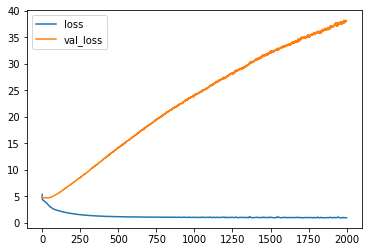

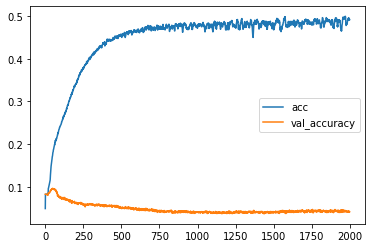

In [15]:
# plot some data
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

# accuracies
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

In [21]:
initial_c.get_shape()

TensorShape([None, 25])

### Now the Prediction Model

We make a separate prediction model by utilizing the trained layers from the previos model

In [22]:
input2 = Input(shape=(1,)) # we pass one word to generate poetry
x = embedding_layer(input2)
x, h, c = lstm(x, initial_state=[initial_h, initial_c]) # now we need the states to feed back in
output2 = dense(x)
sampling_model = Model([input2, initial_h, initial_c], [output2, h, c])

In [24]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 12)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           multiple             150000      input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 25)]         0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 25)]         0                                            
______________________________________________________________________________________________

In [23]:
sampling_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           multiple             150000      input_4[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 25)]         0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 25)]         0                                            
____________________________________________________________________________________________

In [25]:
# reverse word2idx to get back words
# during prediction
idx2word = {v:k for k,v in word2idx.items()}

In [41]:
def sample_line():
  # initial inputs
  np_input = np.array([[word2idx['<sos>']]])
  h = np.zeros([1, LATENT_DIM])
  c = np.zeros([1, LATENT_DIM])

  # so we know when to quit
  eos = word2idx['<eos>']

  # store the output line
  output_sentence = []

  for _ in range(max_sequence_length):
    o, h, c = sampling_model.predict([np_input, h, c])

    probs = o[0,0] # at each input word, the model will output a list
                   # of probabilities of the next word
    # handle special cases when the model outputs high probability for index 0
    # which does not correspond to any word.
    if np.argmax(probs) == 0:
      print('wtf')
    probs[0] = 0 # ensure first index is 0 probability
    probs /= probs.sum() # re normalize because we force one prob to be 0
    # now random sample from the probability distribution
    idx = np.random.choice(len(probs), p=probs)
    if idx == eos: # if sampled index correponds to eos, break
      break

    # accumulate the output
    output_sentence.append([idx2word.get(idx, '<WTF %s>'% idx)])

    # put back this input back into the model to predic next word
    np_input[0,0] = idx

  return ' '.join(str(val) for val in output_sentence)


In [42]:
# generate a 4 line poem
while True:
  for _ in range(4):
    print(sample_line())
  
  ans = input("-----generate another? [Y/n]------")
  if ans and ans[0].lower().startswith('n'):
    break

['he'] ['reeled,'] ['he'] ['lurched,'] ['he'] ['bobbed,'] ['he'] ['checked;']
['with'] ['the'] ['furthest'] ['bodies']
['i'] ['fancied'] ['when'] ['i'] ['was'] ['young.'] ['chimney:'] ['but'] ["attic.'"]
['in'] ['warren'] ['at'] ['being'] ['age'] ['outdoors.']
-----generate another? [Y/n]------n
